In [58]:
import os
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import numpy as np
from skimage import feature
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2hsv
from skimage.filters import threshold_sauvola
from skimage.segmentation import mark_boundaries
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
from shapely.geometry import box, mapping
import geopandas as gpd
import rasterio
import rasterio.plot
import glob
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Union

In [2]:
logger = log.get_logger(__name__)

In [3]:
conf = utils.load_config("base")

23-Dec-23 00:55:31 - INFO - Starting 'load_config'.
23-Dec-23 00:55:31 - INFO - Finished 'load_config' in 0.0676 secs.


In [4]:
rgb_fns = utils.get_filenames(conf.data.path_int_cr_tif, "tif", 'rgb')
chm_fns = utils.get_filenames(conf.data.path_int_cr_tif, "npy", 'chm')
hyps_fns = utils.get_filenames(conf.data.path_int_cr_tif, "tif", 'hyps')

In [66]:
def load_rgb_images(image_paths):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        images.append(img_rgb)
    return np.array(images)


def load_grayscale_images(image_paths):
    images = []
    for path in image_paths:
        img = np.load(path)
        images.append(img)
    return np.array(images)


def load_hyperspectral_images(image_paths):
    images = []
    for path in image_paths:
        with rasterio.open(path) as src:
            img = src.read()
            # Transpose the image to have channels last
            # img = img.transpose((1, 2, 0))
            images.append(img)
    return images


def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalizes the pixel values of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The normalized image.
    """
    # Normalize the image to the range [0, 255]
    normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return normalized_image


def create_center_segment_mask(segmentation: np.ndarray, image_shape: Tuple[int, int]) -> np.ndarray:
    # Step 1: Identify the center point of the image
    center_point = (image_shape[0] // 2, image_shape[1] // 2)
    # Step 2: Identify the segment label at the center point
    center_segment_label = segmentation[center_point]
    # Step 3: Create a mask by comparing the segmentation array with the center segment label
    mask = segmentation == center_segment_label
    logger.info(f'Mask shape: {mask.shape}')
    return mask


def apply_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    # Ensure mask is boolean
    mask = mask.astype(bool)

    # If the image has more than one channel, we need to adjust the mask to have the same number of channels
    if image.ndim > 2:
        # Expand dimensions of the mask to match the image
        mask = np.stack([mask]*image.shape[-1], axis=-1)

    # Apply the mask to the image
    masked_image = image * mask
    return masked_image


def plot_masked_images_segments(image_dict, save = False, out_dir = None, fn = None):
    num_images = len(image_dict['original'])
    
    # Set up the plot with num_images rows and 3 columns
    fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(12, 4*num_images))

    for i in range(num_images):
        # Plot the original image in the first column
        axes[i, 0].imshow(image_dict['original'][i])
        axes[i, 0].set_title('Original Image')

        # Plot the segmented image with boundaries in the second column
        axes[i, 1].imshow(mark_boundaries(image_dict['original'][i], image_dict['segmented'][i]))
        axes[i, 1].set_title('Segmented Image')

        # Plot the masked image in the third column
        axes[i, 2].imshow(image_dict['masked'][i])
        axes[i, 2].set_title('Masked Image')

    if save:
        utils.save_plot(fig, f"{out_dir}segmented_{fn}.png")
        logger.info(f"Saved plot to {out_dir}segmented_{fn}.png")
    else:
        plt.tight_layout()
        plt.show()

In [60]:
with rasterio.open("../data/02_intermediate/03_cropped_tifs/71_rgb_Other.tif") as src:
    img = src.read()

In [61]:
img.shape

(4, 87, 87)

In [62]:
normalized_image = normalize_image(img)
segments = felzenszwalb(normalized_image, scale=100, sigma=0.5, min_size=50)

/var/folders/0g/blggksdj42z52nv3fy0h5b880000gn/T/ipykernel_19984/2056661069.py:2: RuntimeWarning: Got image with third dimension of 87. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(normalized_image, scale=100, sigma=0.5, min_size=50)


In [63]:
segments.shape

(4, 87)

In [64]:
mask = create_center_segment_mask(segments, normalized_image.shape[:2])

23-Dec-23 17:27:34 - INFO - Mask shape: (4, 87)


In [67]:
# Step 4: Apply the mask to the normalized image
masked_image = apply_mask(normalized_image, mask)

In [74]:
image_data = np.transpose(img, (1, 2, 0))

In [77]:
image_data.shape

(87, 87, 4)

In [80]:
img.shape

(4, 87, 87)

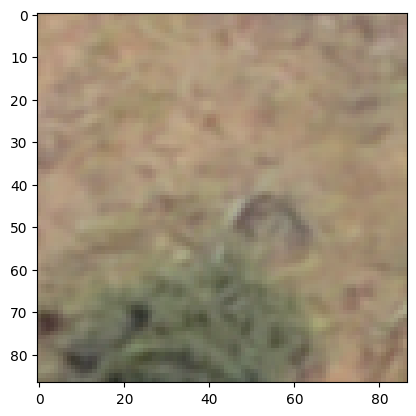

In [82]:
plt.imshow(image_data)

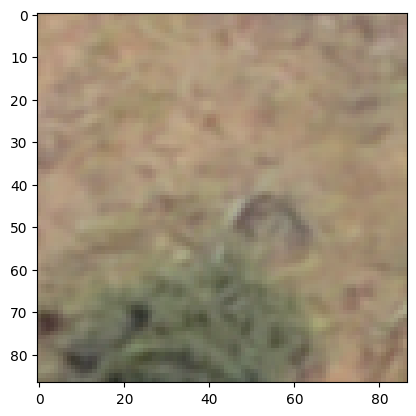

<Axes: >

In [79]:
rasterio.plot.show(img)

In [75]:
rgb_dct = {'original': [image_data, image_data], 'segmented': [segments, segments], 'masked': [masked_image, masked_image]}

IndexError: boolean index did not match indexed array along dimension 0; dimension is 87 but corresponding boolean dimension is 4

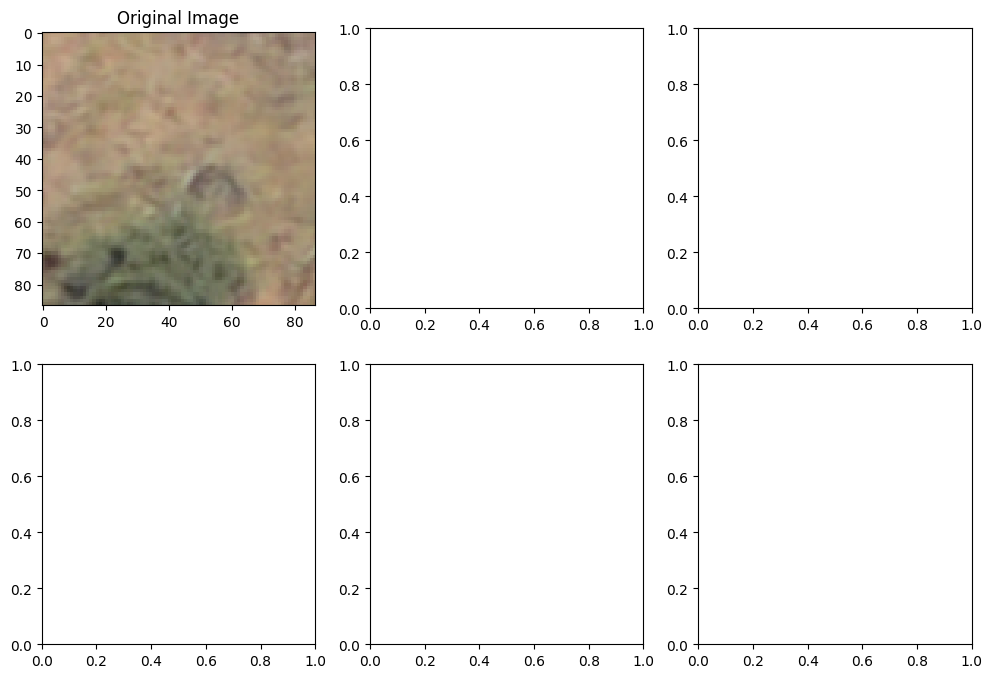

In [76]:
plot_masked_images_segments(rgb_dct, save=True, out_dir=conf.data.path_rep, fn=conf.data.fn_rgba)

In [7]:
rgb_imgs = load_hyperspectral_images(rgb_fns)
chm_imgs = load_grayscale_images(chm_fns)
hyps_imgs = load_hyperspectral_images(hyps_fns)

In [28]:
np.min(chm_imgs[1]), np.max(chm_imgs[1]), np.mean(chm_imgs[1]), np.std(chm_imgs[1]), np.median(chm_imgs[1])

(0, 255, 1.8574448407979918, 21.65773218326121, 0.0)

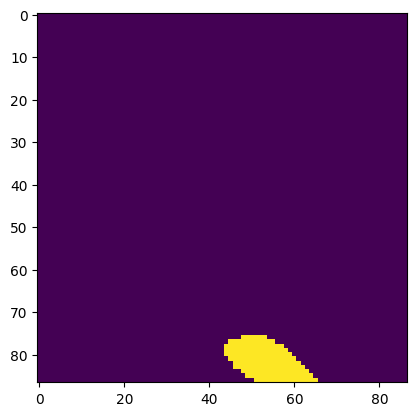

(0, 255, 5.3230281411018625, 36.45596723980881, 0.0)

In [36]:
chm_img = normalize_image(chm_imgs[5])
rasterio.plot.show(chm_img)
np.min(chm_img), np.max(chm_img), np.mean(chm_img), np.std(chm_img), np.median(chm_img)

In [15]:
new_hyps = hyps_imgs[0][:, :, 0]
new_hyps.shape

(87, 87)

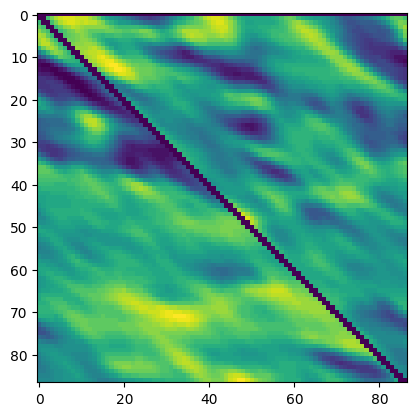

<Axes: >

In [17]:
rasterio.plot.show(hyps_imgs[3][:, :, 0])

In [21]:
rgb_img = rgb_imgs[0][:, :, 0]

In [26]:
rgb_fns[0]

'../data/02_intermediate/03_cropped_tifs/146_rgb_Other.tif'

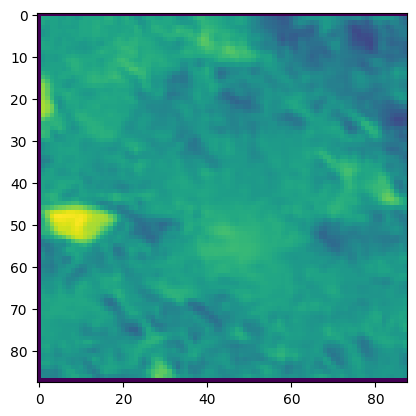

<Axes: >

In [22]:
rasterio.plot.show(rgb_imgs[0][:, :, 0])

In [23]:
normalized_image = normalize_image(rgb_img)

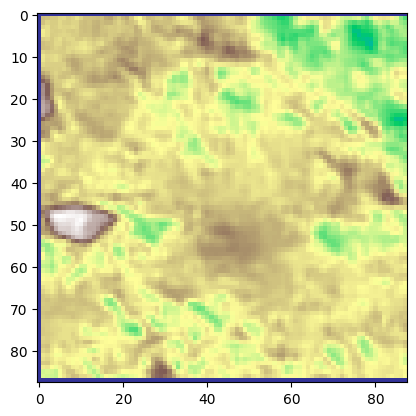

<Axes: >

In [27]:
rasterio.plot.show(normalized_image, cmap='terrain')

In [37]:
rgb_fns_png = utils.get_filenames(conf.data.path_int_cr_img, "png", 'rgb')
rgb_imgs_png = load_hyperspectral_images(rgb_fns)

In [38]:
rgb_img_png = rgb_imgs_png[0][:, :, 0]

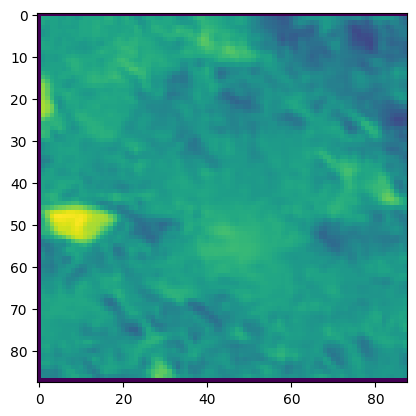

<Axes: >

In [40]:
rasterio.plot.show(rgb_img_png)

In [41]:
rgb_img_png_norm = normalize_image(rgb_img_png)

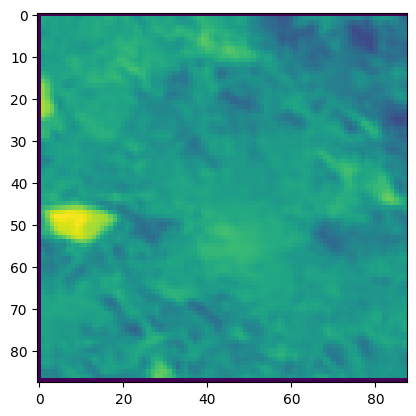

<Axes: >

In [42]:
rasterio.plot.show(rgb_img_png_norm)